# 흐린 사진을 선명하게

## 0. 모듈 import

In [1]:
import os
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from skimage import data
from IPython.display import Image as show_gif
from tensorflow.keras import Input, Model, layers

## 1. SRGAN 모델

SRGAN 모델을 학습시키는데 많은 학습 시간이 필요하다.  
따라서 DIV2K 데이터 셋으로 미리 학습된 모델을 사용한다.  

DIV2K에 대한 자세한 정보는 다음에서 확인 가능하다.

https://data.vision.ee.ethz.ch/cvl/DIV2K/

In [2]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [3]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기

### 프로젝트 1-1

### 고해상도 이미지를 불러오자.

(1200, 1920, 3)


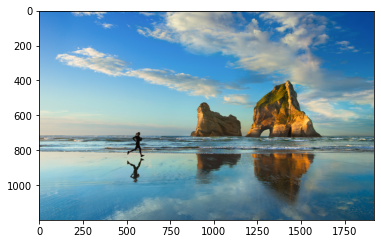

In [4]:
img_hr = cv2.imread('images/img_1920_1200.jpg')
img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)

print(img_hr.shape)
plt.imshow(img_hr)

### 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄인다.

(300, 480, 3)


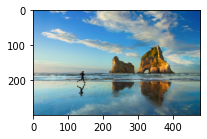

In [5]:
img_lr = cv2.resize(img_hr, (img_hr.shape[1]//4, img_hr.shape[0]//4), cv2.INTER_CUBIC)

print(img_lr.shape)
plt.figure(figsize=(3,3))
plt.imshow(img_lr)

### 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성한다.

(1200, 1920, 3)


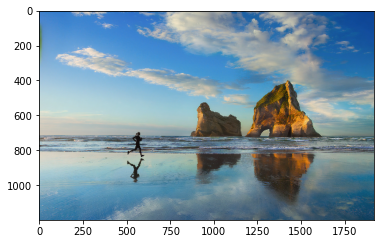

In [6]:
srgan_hr = apply_srgan(img_lr)

print(srgan_hr.shape)
plt.imshow(srgan_hr)

### 저해상도 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘린다.

(1200, 1920, 3)


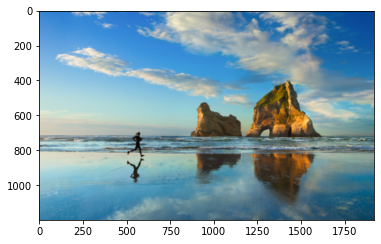

In [7]:
bicubic_hr = cv2.resize(img_lr, (img_hr.shape[1], img_hr.shape[0]), cv2.INTER_CUBIC)

print(bicubic_hr.shape)
plt.imshow(bicubic_hr)

### 3개 이미지를 나란히 시각화시켜보자.

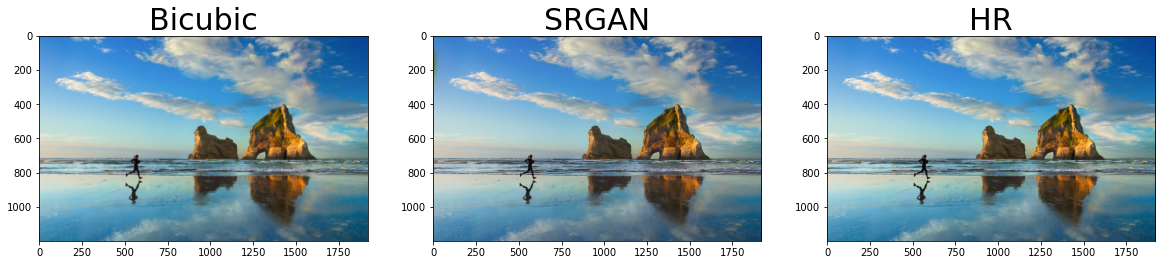

In [8]:
images = [bicubic_hr, srgan_hr, img_hr]
labels = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(20, 30))
for i in range(3):
    plt.subplot(1,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

특정부분만 잘라서 비교를 해보자.

In [9]:
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

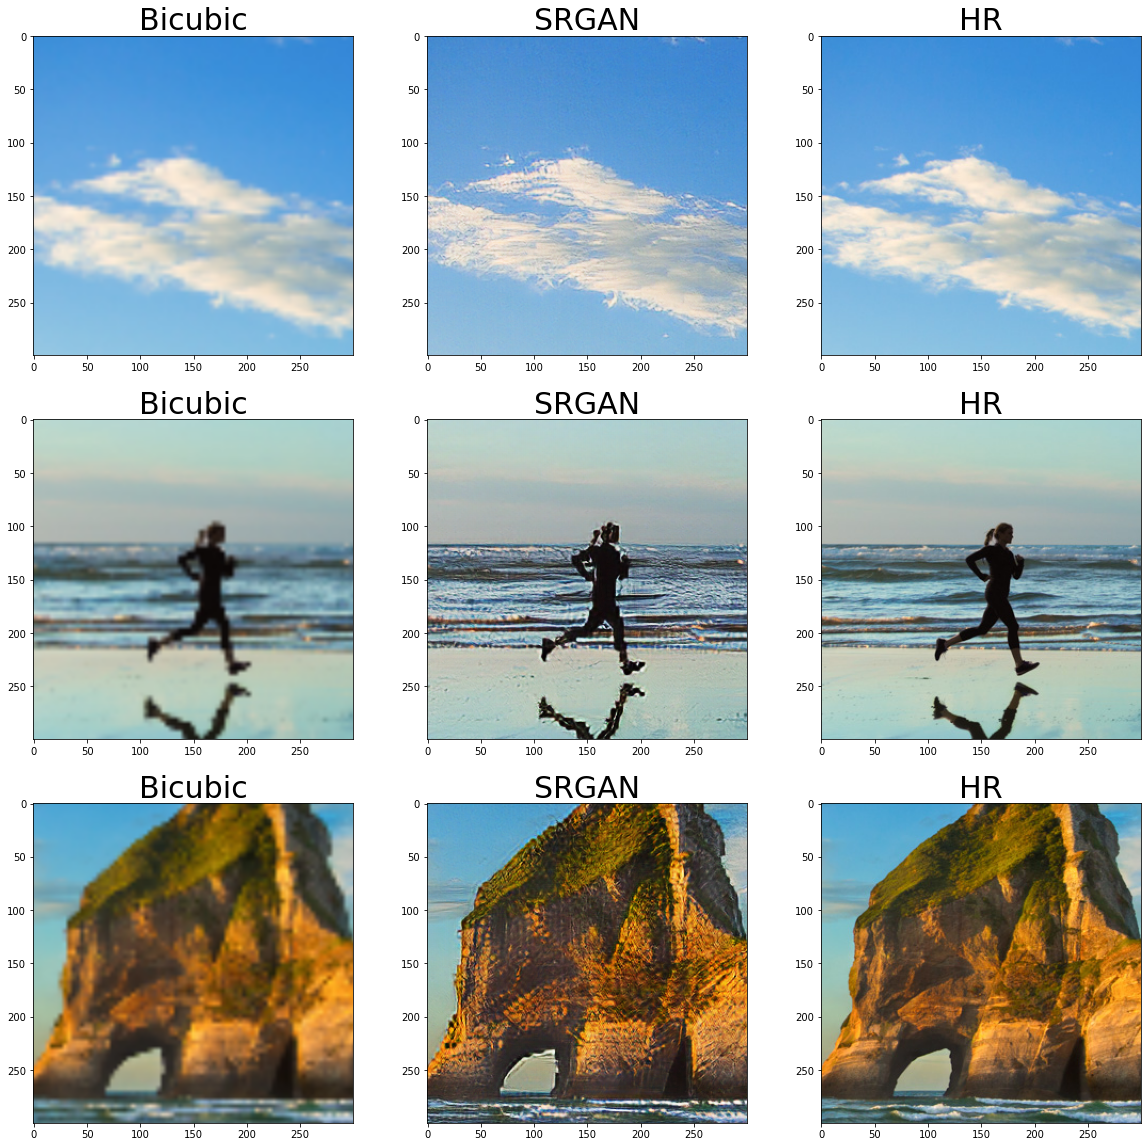

In [10]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(100, 150), (600, 400), (450, 1200)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 300, 300)
    img2 = crop(srgan_hr , left_top, 300, 300)
    img3 = crop(img_hr, left_top, 300, 300)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3


plt.figure(figsize=(20, 20))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

### 결과분석

ㅇㄴㅇㅁㄴ

### 프로젝트 1-2

### 저해상도 이미지를 불러오자.

(300, 480, 3)


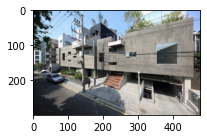

In [11]:
img_lr = cv2.imread('images/img_480_300.jpg')
img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)

print(img_lr.shape)
plt.figure(figsize=(3,3))
plt.imshow(img_lr)

### 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성

(1200, 1920, 3)


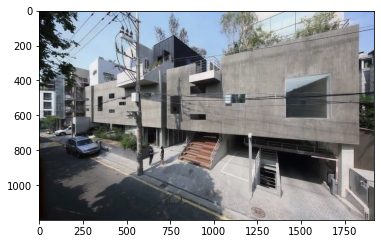

In [12]:
srgan_hr = apply_srgan(img_lr)

print(srgan_hr.shape)
plt.imshow(srgan_hr)

###  저해상도 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를  4배로 늘린다.

(1200, 1920, 3)


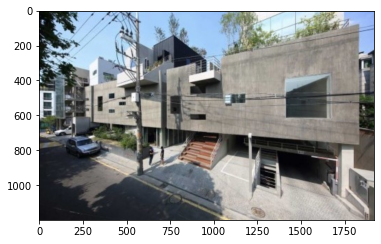

In [13]:
bicubic_hr = cv2.resize(img_lr, (img_hr.shape[1], img_hr.shape[0]), cv2.INTER_CUBIC)

print(bicubic_hr.shape)
plt.imshow(bicubic_hr)

### 고해상도로 만든 2개 이미지를 나란히 시각화해보자.

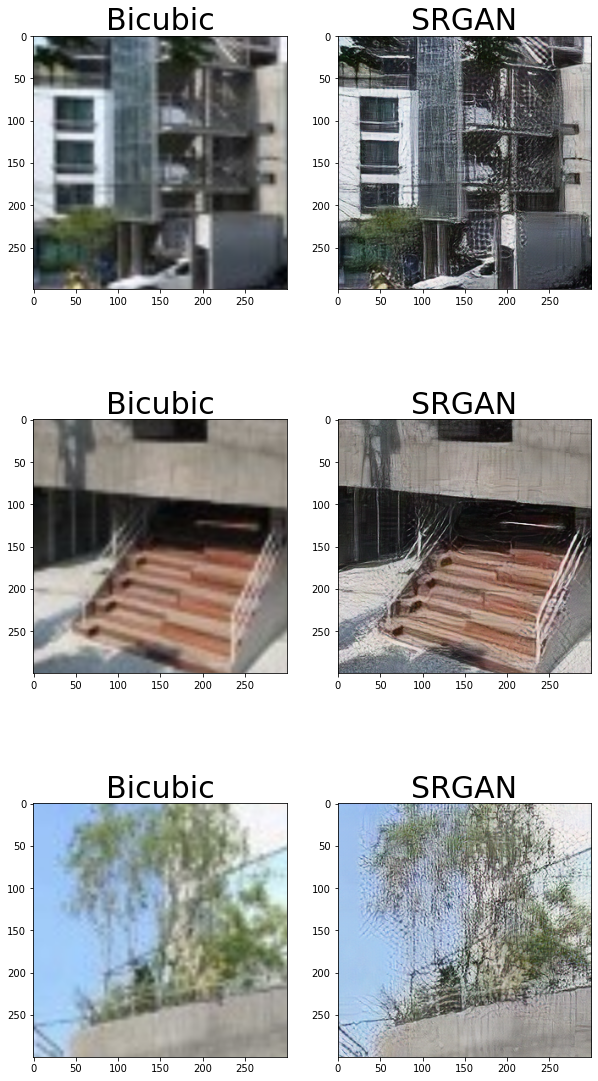

In [14]:
left_tops = [(400, 0), (600, 750), (0, 1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 300, 300)
    img2 = crop(srgan_hr , left_top, 300, 300)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3


plt.figure(figsize=(10, 20))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

### 결과분석

ㄴㅇㄱ

## 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

### gif 파일 불러오기

In [15]:
gif = cv2.VideoCapture("images/metro_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 35
frame 크기 : (252, 282, 3)


### 프레임별 Super Resolution 진행하기

In [16]:
frames_sr = [apply_srgan(frame) for frame in frames]

### 프레임을 합쳐 gif 만들기

In [17]:
imageio.mimsave("images/metro_sr.gif", frames_sr)

### gif 출력하기

<img src = "images/metro_lr.gif" align='left' width ="400"> <img src = "images/metro_sr.gif"  width ="400">

## 회고